In [38]:
from torch import nn
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torchvision import datasets, transforms, utils
from src.utility import convert_image_np
import tqdm
from collections import defaultdict
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import gridspec
from lib.data import Mimic2
from lib.utility import show_tensor_image, show_acc, to_var
from lib.model import MLP
from lib.openbox import open_box, count_config, find_x
from torch.utils.data import Dataset, DataLoader

In [6]:
def train(net, trainloader, criterion, optimizer, print_every=None, epochs=1000, max_time=10):
    net.train()
    start = time.time()
    
    # max_time given in seconds
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (x, y) in enumerate(trainloader):
            
            end = time.time()
            if end - start >= max_time:
                print('Finished Training in %ds' % (end-start))                
                return
            
            # get the inputs
            x, y = to_var(x), to_var(y)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data.item()
            if print_every is not None and i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training in %ds' % (end-start))

# CNN

In [7]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(-1, 320)
        x = self.classifier(x)
        return x

net = CNN()
x = to_var(torch.randn(28 * 28).view(1, 1, 28, 28))
net(x)

tensor([[ 0.1167,  0.0232, -0.0481,  0.0121, -0.2342, -0.1280, -0.1694, -0.0149,
          0.1106, -0.1351]], grad_fn=<ThAddmmBackward>)

CNN(
  (feature): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace)
  )
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


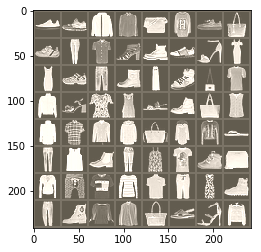

[1,   400] loss: 0.7698635544
[1,   800] loss: 0.4834734470
[2,   400] loss: 0.3994170920
[2,   800] loss: 0.3740400125
[3,   400] loss: 0.3460416419
[3,   800] loss: 0.3204300522
[4,   400] loss: 0.3051008566
[4,   800] loss: 0.3024511766
[5,   400] loss: 0.2888925447
[5,   800] loss: 0.2834738873
[6,   400] loss: 0.2624333514
Finished Training in 300s


In [22]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False)

net = CNN()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)

x, y = next(iter(train_loader))
show_tensor_image(x)

train(net, train_loader, criterion, optimizer, print_every=400, epochs=10, max_time=300)

In [23]:
show_acc(net, test_loader)

Accuracy of the network on 10000  images: 88 %


In [87]:
torch.randint(0, 10, (10,))

tensor(0.)

In [36]:
type(d[1][1])

torch.Tensor

# auxilliary task

In [88]:
class AuxDataset(Dataset):
    
    def __init__(self, dataset):
        self.dataset = dataset
        # create a random assignment for aux tasks
        self.y_aux = torch.randint(0, 10, (len(self.dataset),)).long()
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return x, [y, self.y_aux[idx]]

In [89]:
class CNN_aux(nn.Module):

    def __init__(self):
        super(CNN_aux, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 20) # 10 more output for auxilliary task
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(-1, 320)
        x = self.classifier(x)
        return x

net = CNN_aux()
x = to_var(torch.randn(28 * 28).view(1, 1, 28, 28))
net(x)

tensor([[-0.1341,  0.0121,  0.1471, -0.0890,  0.0684, -0.0041, -0.0106, -0.1297,
         -0.0549, -0.0976, -0.0570,  0.1646, -0.0078,  0.1045, -0.1846, -0.0848,
          0.0334, -0.0065,  0.3080,  0.0149]], grad_fn=<ThAddmmBackward>)

In [96]:
def aux_criteria(aux_weight=0.1, orig_weight=1):
    
    def ret(outputs, y):
        loss = nn.CrossEntropyLoss()
        l = 0
        l += orig_weight * loss(outputs[:,:10], y[0])
        l += aux_weight * loss(outputs[:,10:], y[1])
        return l
    
    return ret


MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=20, bias=True)
  )
)


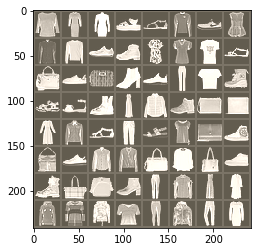

[1,   400] loss: 2.3067021215
[1,   800] loss: 2.3055333757
[2,   400] loss: 2.3045384711
[2,   800] loss: 2.3040287322
[3,   400] loss: 2.3034377044
[3,   800] loss: 2.3030797386
[4,   400] loss: 2.3031915426
[4,   800] loss: 2.3033197963
[5,   400] loss: 2.3030131811
[5,   800] loss: 2.3031543988
[6,   400] loss: 2.3030755830
[6,   800] loss: 2.3028701818
[7,   400] loss: 2.3028641826


KeyboardInterrupt: 

In [99]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    AuxDataset(datasets.FashionMNIST('fmnist_data', train=True, download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.1307,), (0.3081,))
                                     ]))),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    AuxDataset(datasets.FashionMNIST('fmnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))),
    batch_size=batch_size, shuffle=False)

net = MLP([28*28, 100, 50, 20], activation=nn.Sigmoid)#CNN_aux()
print(net)

aux_weight = 1
orig_weight = 0
criterion = aux_criteria(aux_weight=aux_weight, orig_weight=orig_weight)
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)

x, y = next(iter(train_loader))
show_tensor_image(x)

train(net, train_loader, criterion, optimizer, print_every=400, epochs=10, max_time=300)

In [100]:
def show_acc_aux(net, loader, name="", aux=False):
    net.eval()
    correct = 0
    total = 0

    for data in loader:
        x, y = data
        x, y = to_var(x), to_var(y)
        if aux:
            outputs = net(x)[:,10:]
            y = y[1]
        else:
            outputs = net(x)[:,:10]
            y = y[0]
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y.data).sum()

    to_p = 'Accuracy of the network on %d %s images: %d %%' % (len(loader.sampler), name, 100 * correct / total)
    print(to_p + (' (aux)' if aux else ''))
    
show_acc_aux(net, test_loader, "fmnist10 test", aux=False)
show_acc_aux(net, train_loader, "fmnist10 train", aux=True)

Accuracy of the network on 10000 fmnist10 test images: 10 %
Accuracy of the network on 60000 fmnist10 train images: 10 % (aux)


# Fashion MNIST Binary Case (Paper Replication)

Lesson learned: multiple class explanation is hard to learn (could be one of future direction), first focus on binary cases

60000it [00:09, 6471.51it/s]
10000it [00:01, 6213.41it/s]


tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1])


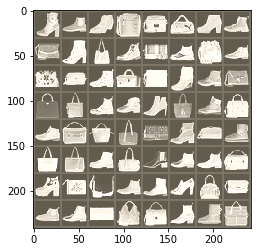

In [26]:
batch_size = 64

classes = [9, 8]

class SelectClasses():
    
    def __init__(self, classes):
        # remap classes labels
        self.classes = classes
    
    def __call__(self, y):
        num_classes = len(self.classes)
        try:
            return self.classes.index(y)
        except:
            return num_classes

train_data = datasets.FashionMNIST('fmnist_data', train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                      ]),
                      target_transform=SelectClasses(classes)
                     )
test_data = datasets.FashionMNIST('fmnist_data', train=False, 
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ]),
                     target_transform=SelectClasses(classes)
                    )

train_subset = []
for i, (x, y) in tqdm.tqdm(enumerate(train_data)):
    if y < len(classes):
        train_subset.append(i)

test_subset = []
for i, (x, y) in tqdm.tqdm(enumerate(test_data)):
    if y < len(classes):
        test_subset.append(i)        
        
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_subset))

test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_subset))

x, y = next(iter(train_loader))
print(y)
show_tensor_image(x)

In [27]:
fmnist1 = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fmnist1.parameters(), weight_decay=1e-4)
train(fmnist1, train_loader, criterion, optimizer, print_every=100, epochs=10, max_time=100)

[1,   100] loss: 0.3079466224
[2,   100] loss: 0.0132972927
[3,   100] loss: 0.0056727782
[4,   100] loss: 0.0050307708
[5,   100] loss: 0.0029191350
[6,   100] loss: 0.0017500488
[7,   100] loss: 0.0031397015
[8,   100] loss: 0.0025999369
[9,   100] loss: 0.0031399317
[10,   100] loss: 0.0024080388
Finished Training in 62s


In [28]:
show_acc(fmnist1, test_loader)

Accuracy of the network on 2000  images: 99 %
